In [33]:
import re
import shutil
import matplotlib as mt
import numpy as np
from pathlib import Path
from langchain_community.document_loaders import DirectoryLoader, PyPDFLoader, UnstructuredEPubLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_chroma import Chroma
from dotenv import load_dotenv
from sklearn.manifold import TSNE
from plotly import graph_objects as go
from langgraph.graph import StateGraph, MessagesState, END
from langchain_core.tools import tool
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display

In [2]:
load_dotenv()

True

In [3]:
folder = Path("Library")
loader = DirectoryLoader(folder, glob="*.pdf", loader_cls=PyPDFLoader)
pdf_docs = loader.load()
print(f"Loaded {len(pdf_docs)} pdf docs.")

loader = DirectoryLoader(folder, glob="*.epub", loader_cls=UnstructuredEPubLoader)
epub_docs = loader.load()
print(f"Loaded {len(epub_docs)} epub docs.")

authors = set()
author_counter = 0
for pdf in pdf_docs:
    author = pdf.metadata['author']
    authors.add(author)
    author_counter += 1
print(f"Found {author_counter}\{len(pdf_docs)} authors: {authors}")

epub_author_pattern = re.compile(r"Library/(.+)\..+\.epub")
author_counter = 0
for epub in epub_docs:
    source = epub.metadata['source']
    author_match = epub_author_pattern.match(source)
    if author_match:
        author = author_match[1]
        authors.add(author)
        epub.metadata['author'] = author
    author_counter += 1
print(f"Found {author_counter}\{len(epub_docs)} authors: {authors}")

documents = pdf_docs + epub_docs
splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = splitter.split_documents(documents)
print(f"From all {len(documents)} documents {len(chunks)} chunks created.")

counter = 0
authors = set()
for c in chunks:
    author = c.metadata['author']
    authors.add(author)
    counter += 1
print(f"Found {counter}\{len(chunks)} authors: {authors}")

embeddings = OpenAIEmbeddings()
db_name = 'library_db'
db_path = Path(db_name)

if db_path.exists():    
    shutil.rmtree(db_path, ignore_errors=True)

store = Chroma(persist_directory=db_name, embedding_function=embeddings)
total_docs = store._collection.count()
print(f"Open persistent vectorstore {db_name}. Found {total_docs} documents.")


def get_batches(chunks, batch_size=512):
    for i in range(0, len(chunks), batch_size):
        yield chunks[i:i+batch_size]

if total_docs == 0:
    for batch in get_batches(chunks):
        store.add_documents(batch)
        
    total_docs = store._collection.count()
    print(f"Added {total_docs} documents.")

Loaded 341 pdf docs.
Loaded 3 epub docs.
Found 341\341 authors: {'Экхарт Толле', 'Dale Carnegie'}
Found 3\3 authors: {'Goulston', 'Экхарт Толле', 'Branden', 'Grin', 'Dale Carnegie'}
From all 344 documents 4279 chunks created.
Found 4279\4279 authors: {'Goulston', 'Экхарт Толле', 'Branden', 'Grin', 'Dale Carnegie'}
Open persistent vectorstore library_db. Found 0 documents.
Added 4279 documents.


In [ ]:
# Optional Visualization
data = store._collection.get(include=['embeddings', 'documents', 'metadatas'])
vectors = np.array(data['embeddings'])

tsne = TSNE(n_components=2, random_state=37)
reduced_vectors = tsne.fit_transform(vectors)

authors = [metadata['author'] for metadata in data["metadatas"]]
author_list = list(set(authors))
cmap = mt.colormaps.get_cmap("tab10")
color_list = [mt.colors.to_hex(cmap(i)) for i in range(len(author_list))]
colors = [color_list[author_list.index(author)] for author in authors]
texts = [f"Author: {author}<br>Text: {doc_text[:100]}" for author, doc_text in zip(authors, data['documents'])]

fig = go.Figure(
    data=go.Scatter(
        x=reduced_vectors[:,0],
        y=reduced_vectors[:,1],
        mode="markers",
        marker=dict(size=5, color=colors, opacity=0.8),
        text=texts,
        hoverinfo='text'
    ),
    layout = go.Layout(
        title="Library Vector Store Visualization",
        width=800,
        height=600
    ),
)

fig.show()

In [13]:
llm = ChatOpenAI(model="gpt-5-mini")

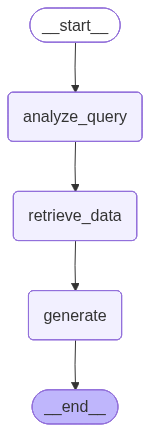

In [91]:
@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = store.similarity_search(query, k=5)
    content = "\n\n".join(f"Metadata: {doc.metadata}, Content: {doc.page_content}" for doc in retrieved_docs)
    return content, retrieved_docs


def analyze_query(state: MessagesState):
    system_prompt = (
        "You are an assistant that helps to create a query for RAG from conversation."
        "Do not answer the question, just transform it to be concise and appropriate for RAG search."
    )
    prompt = [SystemMessage(system_prompt)] + state['messages']
    resp = llm.invoke(prompt)
    return {"messages": [resp]}

def retrieve_data(state: MessagesState):
    query = state['messages'][-1].content
    retrieved_docs = store.similarity_search(query, k=5)
    content = "\n\n".join(f"Metadata: {doc.metadata}, Content: {doc.page_content}" for doc in retrieved_docs)
    
    print("-"*37)
    log = "\n".join(set(f"Author: {doc.metadata['author']}, Book: {doc.metadata['source']}" for doc in retrieved_docs))
    print(log)
    print("-"*37)
    
    messages = state['messages'][:-1] + [{'role': 'ai', 'content': content}]
    return {"messages": messages}


def generate(state: MessagesState):
    tool_message = state['messages'][::-1]

    system_prompt = (
        "You are an assistant for question-answering tasks. "
        "Use only the following pieces of retrieved context to answer "
        "the question. Don't make up anything. If you don't know the answer, say that you "
        "don't know. Use ten sentences maximum and keep the answer concise ."
        "Tell the author and the source of the answer separated by new line like "
        "[Источники: \n"
            "\tАвтор: author, Книга: source\n"
            "\tАвтор: author, Книга: source]"
        "\n\n"
        f"{tool_message}"
    )

    conversation_messages = [m for m in state['messages'] 
                            if m.type in ('human', 'system') or (m.type == 'ai' and not m.tool_calls)]

    prompt = [SystemMessage(system_prompt)] + conversation_messages
    
    resp = llm.invoke(prompt)
    return {'messages': [resp]}

graph_builder = StateGraph(MessagesState).add_sequence([analyze_query, retrieve_data, generate])
# graph_builder.add_node(analyze_query)
# graph_builder.add_node(retrieve_data)
# graph_builder.add_node(generate)

graph_builder.set_entry_point("analyze_query")
# graph_builder.add_edge("query_or_respond", "tools")
# graph_builder.add_conditional_edges(
#     "query_or_respond",
#     tools_condition,
#     {END: END, "tools": "tools"}
# )
# graph_builder.add_edge("tools", "generate")
# graph_builder.add_edge("generate", END)


memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)
config = {"configurable": {"thread_id": "123"}}

display(Image(graph.get_graph().draw_mermaid_png()))

In [92]:
input = "Что такое трансформеры?"
resp = graph.invoke({"messages": [{'role': 'user', 'content': input}]}, config=config)
# print(resp['messages'][-1].pretty_print())
print(resp['messages'][-1].content)

# for m in resp['messages']:
#     m.pretty_print()

# for step in graph.stream(
#     {"messages": [{'role': 'user', 'content': input}]},
#     stream_mode="values",
#     config=config
# ):
#     step["messages"][-1].pretty_print()

-------------------------------------
Author: Branden, Book: Library/Branden.Shest_Stolpov_Samoocenki.epub
Author: Goulston, Book: Library/Goulston.Ya_Slyishu_Vas_Naskvoz.epub
-------------------------------------
Я не могу ответить на вопрос «Что такое трансформеры?» на основании предоставенных фрагментов — в них нет определения трансформеров ни в смысле нейросетей, ни в электрике, ни как франшизы. Уточните, какой смысл вас интересует, и я постараюсь найти определение.

[Источники: 
	Автор: Goulston, Книга: Library/Goulston.Ya_Slyishu_Vas_Naskvoz.epub
	Автор: Branden, Книга: Library/Branden.Shest_Stolpov_Samoocenki.epub]


In [93]:
import gradio as gr

def chat(message, history):
    resp = graph.invoke({"messages": [{'role': 'user', 'content': message}]}, config=config)
    return resp['messages'][-1].content

ui = gr.ChatInterface(fn=chat, type="messages")
ui.launch(inbrowser=True)

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


-------------------------------------
Author: Goulston, Book: Library/Goulston.Ya_Slyishu_Vas_Naskvoz.epub
-------------------------------------
-------------------------------------
Author: Grin, Book: Library/Grin.48_Zakonov_Vlasti.epub
Author: Goulston, Book: Library/Goulston.Ya_Slyishu_Vas_Naskvoz.epub
Author: Branden, Book: Library/Branden.Shest_Stolpov_Samoocenki.epub
-------------------------------------
